In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
from mtcnn.mtcnn import MTCNN
import matplotlib.patches as patches
import random
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output
import imageio
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, LeakyReLU, Reshape, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [2]:
DATASET_PATH ="lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "lfw_attributes.txt"

In [3]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("\\")[-2]
    dataset.append({"person":person, "path": path})
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

,person,path
0,Aaron_Eckhart,lfw-deepfunneled/lfw-deepfunneled\Aaron_Eckhar...
1,Aaron_Guiel,lfw-deepfunneled/lfw-deepfunneled\Aaron_Guiel\...
2,Aaron_Patterson,lfw-deepfunneled/lfw-deepfunneled\Aaron_Patter...
3,Aaron_Peirsol,lfw-deepfunneled/lfw-deepfunneled\Aaron_Peirso...
4,Aaron_Peirsol,lfw-deepfunneled/lfw-deepfunneled\Aaron_Peirso...
5,Aaron_Peirsol,lfw-deepfunneled/lfw-deepfunneled\Aaron_Peirso...
6,Aaron_Peirsol,lfw-deepfunneled/lfw-deepfunneled\Aaron_Peirso...
7,Aaron_Pena,lfw-deepfunneled/lfw-deepfunneled\Aaron_Pena\A...
8,Aaron_Sorkin,lfw-deepfunneled/lfw-deepfunneled\Aaron_Sorkin...
9,Aaron_Sorkin,lfw-deepfunneled/lfw-deepfunneled\Aaron_Sorkin...


<AxesSubplot: xlabel='person'>

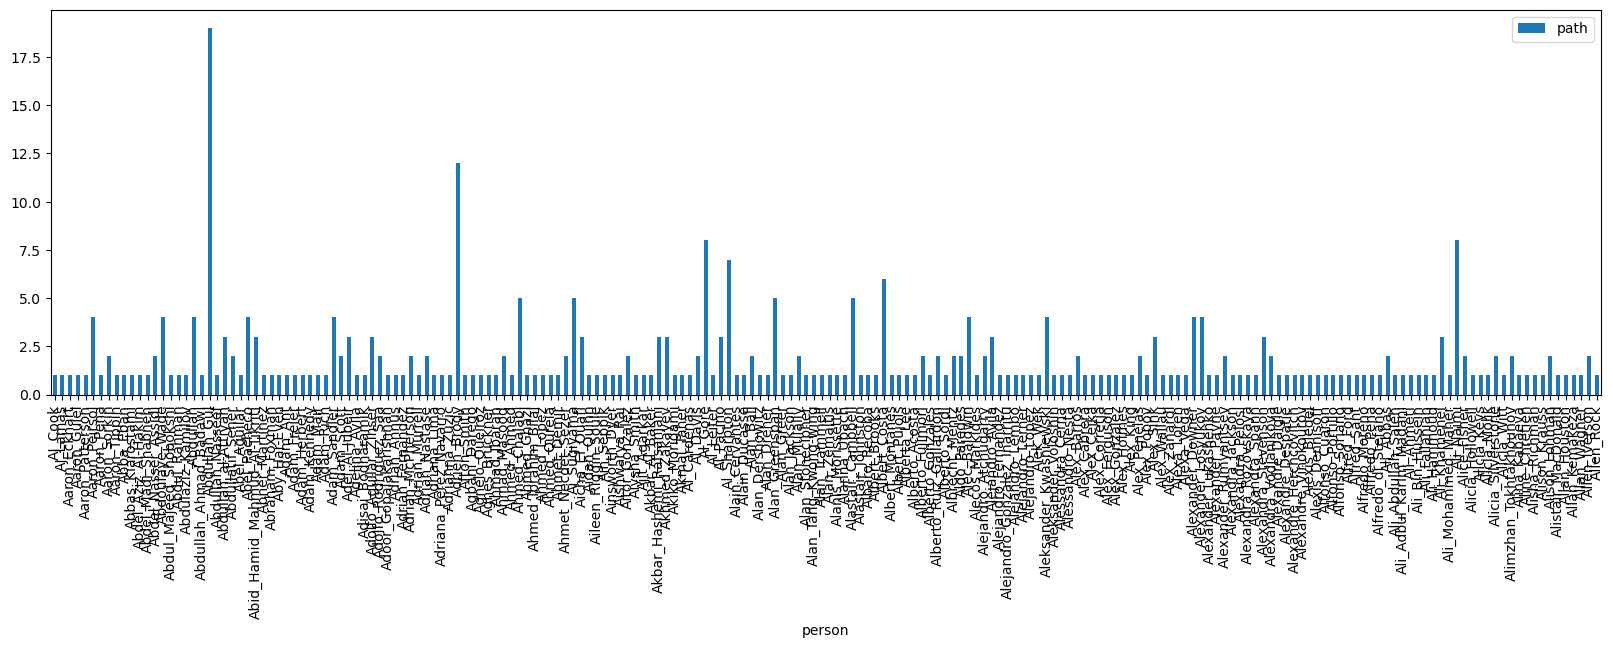

In [4]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

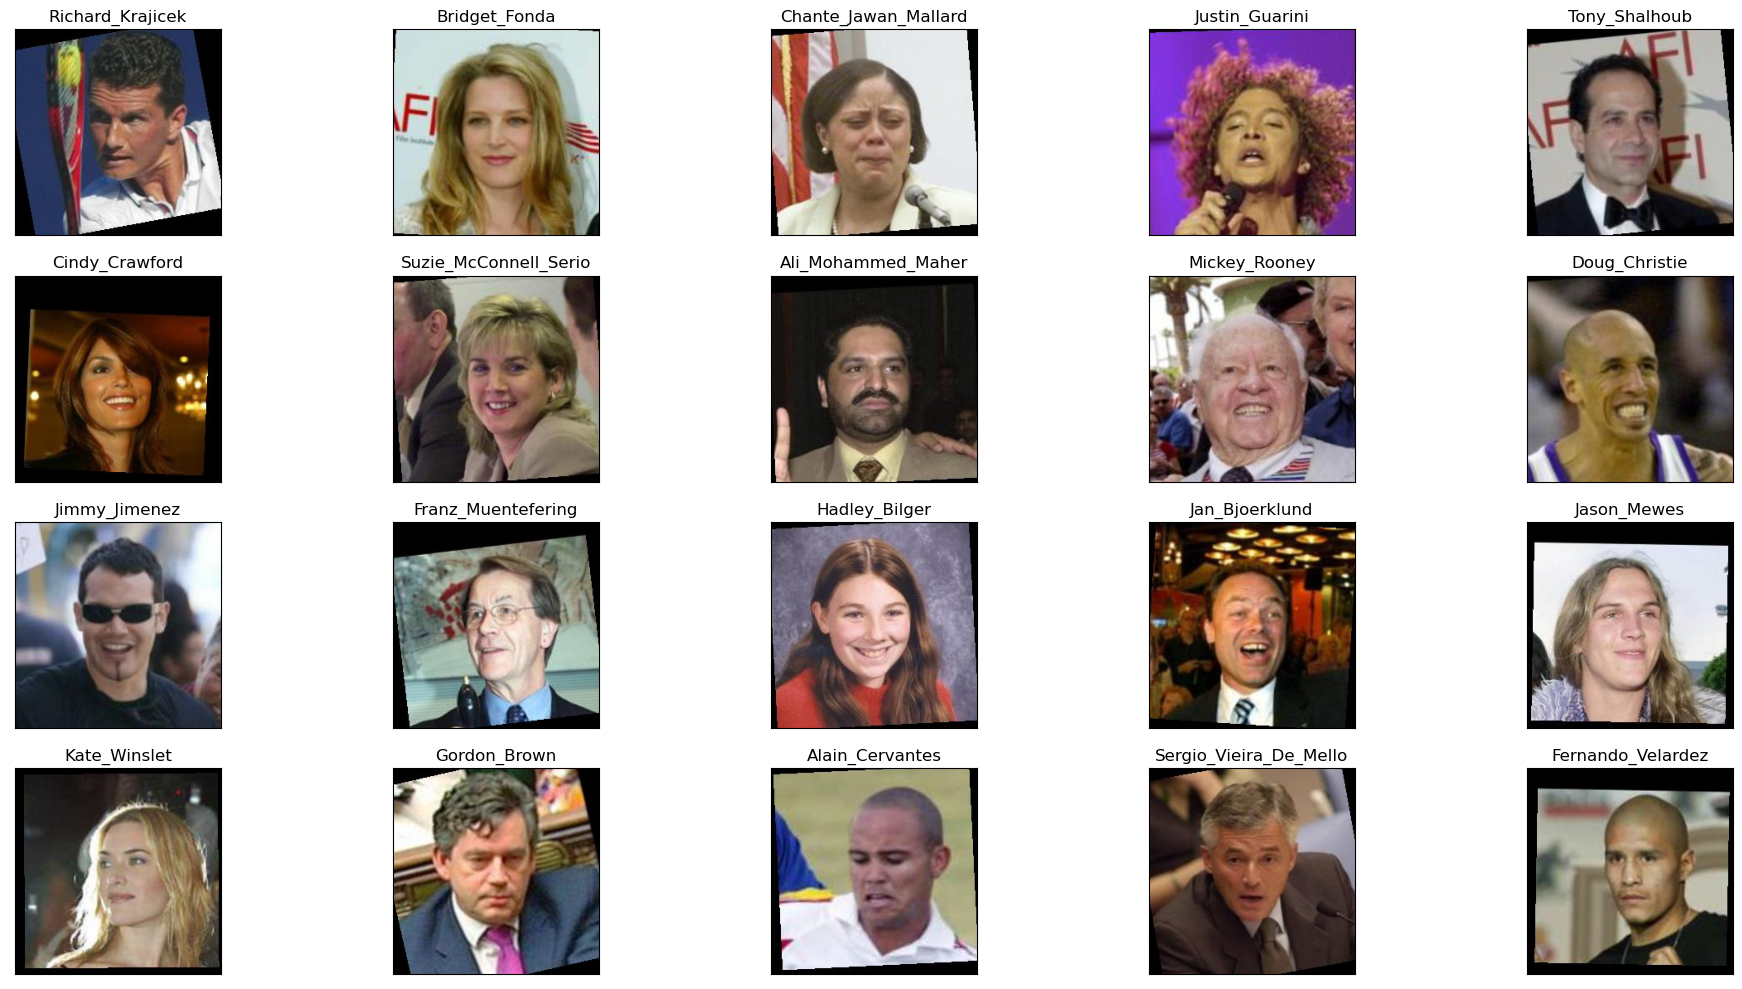

In [5]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [6]:
def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs



In [10]:
data, attrs = fetch_dataset()

In [11]:
#45,45
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

In [12]:
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [13]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

## VAE

In [32]:
dim_z = 256

In [33]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc4 = nn.Linear(1500, 45*45*3)        
        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
    
    def return_Z(self, x):
        x = self.relu(self.fc1(x))
        mu, logvar = self.fc21(x), self.fc22(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        return z
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = self.relu(self.fc3(z)) #1500
        return torch.sigmoid(self.fc4(z))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar
    
def loss_vae_fn(x, recon_x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [34]:
model_vae = VAE().to(DEVICE)

In [35]:
def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)        
        optimizer.zero_grad()
        
        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(DEVICE)
        
        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)        
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]         
        pic_input = pic.view(-1, 45*45*3)            
        pic_input = pic_input.to(DEVICE)        
        decoded,mu,logvar = model(inputs)        
        pic_output = decoded[0].view(-1, 45*45*3).squeeze()
        pic_output = pic_output.to("cpu") 
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   3%|██▌                                                                         | 1/30 [00:01<00:41,  1.43s/it]

loss:  508559.971872325

Epoch 001 train_loss: 508559.9719 val_loss: 493425.3250


epoch:   7%|█████                                                                       | 2/30 [00:02<00:34,  1.23s/it]

loss:  495539.0589110353

Epoch 002 train_loss: 495539.0589 val_loss: 488891.7922


epoch:  10%|███████▌                                                                    | 3/30 [00:03<00:30,  1.14s/it]

loss:  493229.21569603623

Epoch 003 train_loss: 493229.2157 val_loss: 487566.0592


epoch:  13%|██████████▏                                                                 | 4/30 [00:04<00:28,  1.09s/it]

loss:  490979.71187821

Epoch 004 train_loss: 490979.7119 val_loss: 485630.1094


epoch:  17%|████████████▋                                                               | 5/30 [00:05<00:26,  1.06s/it]

loss:  490399.0813468946

Epoch 005 train_loss: 490399.0813 val_loss: 483750.0063


epoch:  20%|███████████████▏                                                            | 6/30 [00:06<00:25,  1.05s/it]

loss:  489022.4883087431

Epoch 006 train_loss: 489022.4883 val_loss: 482487.0023


epoch:  23%|█████████████████▋                                                          | 7/30 [00:07<00:24,  1.05s/it]

loss:  487856.1553509012

Epoch 007 train_loss: 487856.1554 val_loss: 481775.3969


epoch:  27%|████████████████████▎                                                       | 8/30 [00:08<00:22,  1.04s/it]

loss:  487094.93877211335

Epoch 008 train_loss: 487094.9388 val_loss: 480965.2526


epoch:  30%|██████████████████████▊                                                     | 9/30 [00:09<00:22,  1.05s/it]

loss:  485768.63785785617

Epoch 009 train_loss: 485768.6379 val_loss: 480596.4144


epoch:  33%|█████████████████████████                                                  | 10/30 [00:10<00:21,  1.07s/it]

loss:  485273.71901601437

Epoch 010 train_loss: 485273.7190 val_loss: 479539.6317


epoch:  37%|███████████████████████████▍                                               | 11/30 [00:12<00:20,  1.09s/it]

loss:  484728.194881527

Epoch 011 train_loss: 484728.1949 val_loss: 479369.9108


epoch:  40%|██████████████████████████████                                             | 12/30 [00:13<00:19,  1.09s/it]

loss:  483799.0481485995

Epoch 012 train_loss: 483799.0481 val_loss: 479149.4494


epoch:  43%|████████████████████████████████▌                                          | 13/30 [00:14<00:18,  1.09s/it]

loss:  483827.5115471039

Epoch 013 train_loss: 483827.5115 val_loss: 479222.7564


epoch:  47%|███████████████████████████████████                                        | 14/30 [00:15<00:17,  1.09s/it]

loss:  483572.9509418989

Epoch 014 train_loss: 483572.9509 val_loss: 478220.5162


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [00:16<00:15,  1.06s/it]

loss:  482702.9630031981

Epoch 015 train_loss: 482702.9630 val_loss: 477816.4438


epoch:  53%|████████████████████████████████████████                                   | 16/30 [00:17<00:14,  1.05s/it]

loss:  483645.4844953752

Epoch 016 train_loss: 483645.4845 val_loss: 480545.9633


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [00:18<00:13,  1.05s/it]

loss:  482520.12716972607

Epoch 017 train_loss: 482520.1272 val_loss: 477427.4335


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [00:19<00:12,  1.06s/it]

loss:  482050.64029656886

Epoch 018 train_loss: 482050.6403 val_loss: 477901.5357


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [00:20<00:11,  1.05s/it]

loss:  481847.403231703

Epoch 019 train_loss: 481847.4032 val_loss: 477728.1983


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [00:21<00:10,  1.03s/it]

loss:  481418.28644248145

Epoch 020 train_loss: 481418.2864 val_loss: 477940.9896


C:\Users\PC\AppData\Local\Temp\ipykernel_20792\1030000551.py:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [00:22<00:09,  1.03s/it]

loss:  481536.615515622

Epoch 021 train_loss: 481536.6155 val_loss: 480578.6150


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [00:23<00:08,  1.02s/it]

loss:  481529.54130504566

Epoch 022 train_loss: 481529.5413 val_loss: 477733.3192


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [00:24<00:07,  1.03s/it]

loss:  481106.1750642001

Epoch 023 train_loss: 481106.1751 val_loss: 476024.6272


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [00:25<00:06,  1.04s/it]

loss:  481473.5093565722

Epoch 024 train_loss: 481473.5094 val_loss: 478937.3610


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [00:26<00:05,  1.08s/it]

loss:  481004.29813522444

Epoch 025 train_loss: 481004.2981 val_loss: 476347.0391


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [00:27<00:04,  1.07s/it]

loss:  480733.60461497767

Epoch 026 train_loss: 480733.6046 val_loss: 476175.6551


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [00:28<00:03,  1.06s/it]

loss:  480465.4408170059

Epoch 027 train_loss: 480465.4408 val_loss: 475446.8866


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [00:29<00:02,  1.05s/it]

loss:  480405.5713275157

Epoch 028 train_loss: 480405.5713 val_loss: 475749.6388


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [00:30<00:01,  1.05s/it]

loss:  480249.52783193835

Epoch 029 train_loss: 480249.5278 val_loss: 475764.7401


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [00:31<00:00,  1.06s/it]

loss:  480060.457043882

Epoch 030 train_loss: 480060.4570 val_loss: 478432.7801


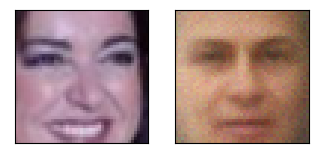

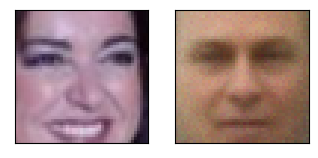

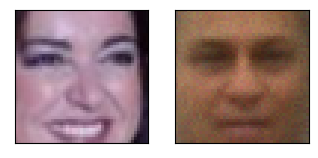

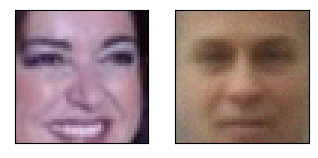

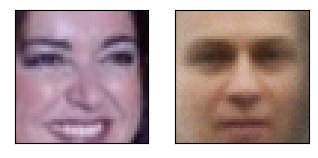

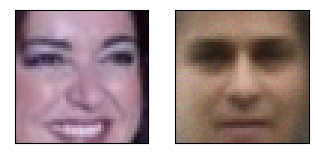

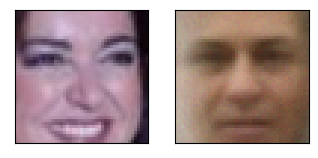

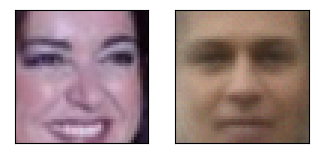

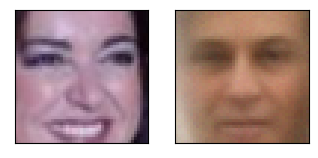

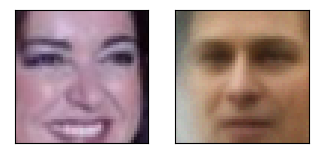

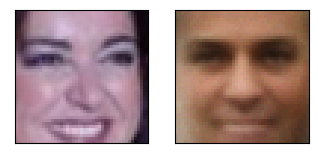

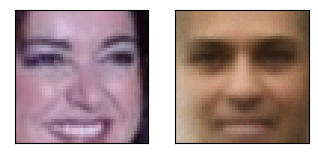

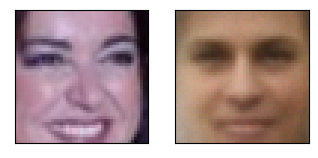

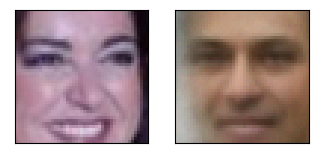

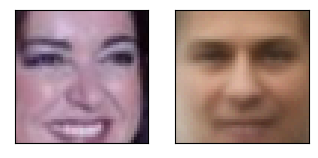

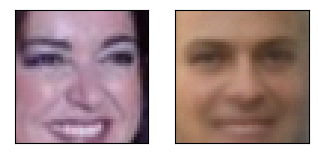

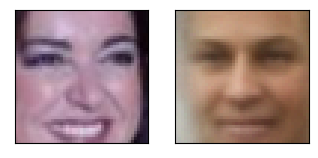

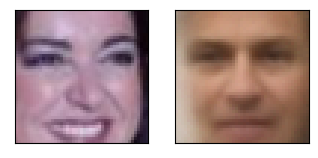

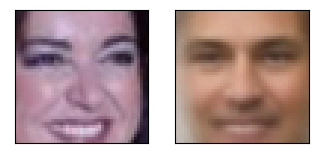

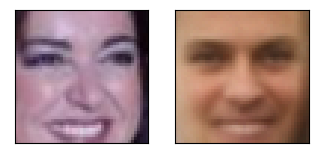

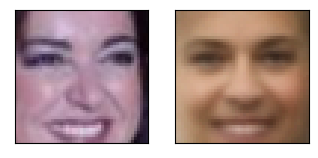

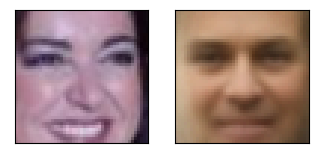

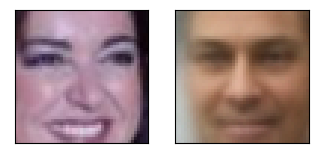

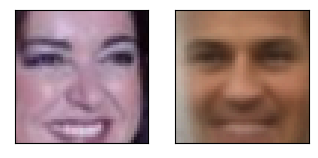

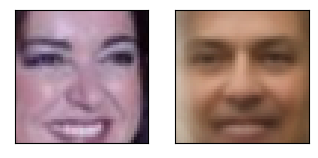

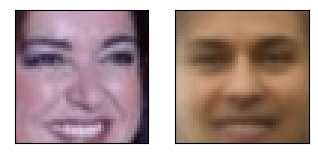

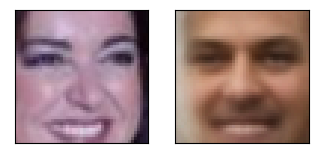

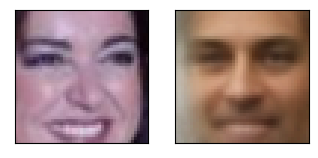

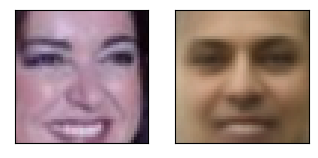

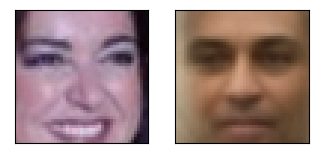

In [36]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=30, batch_size=128, lr=0.001)

In [42]:
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

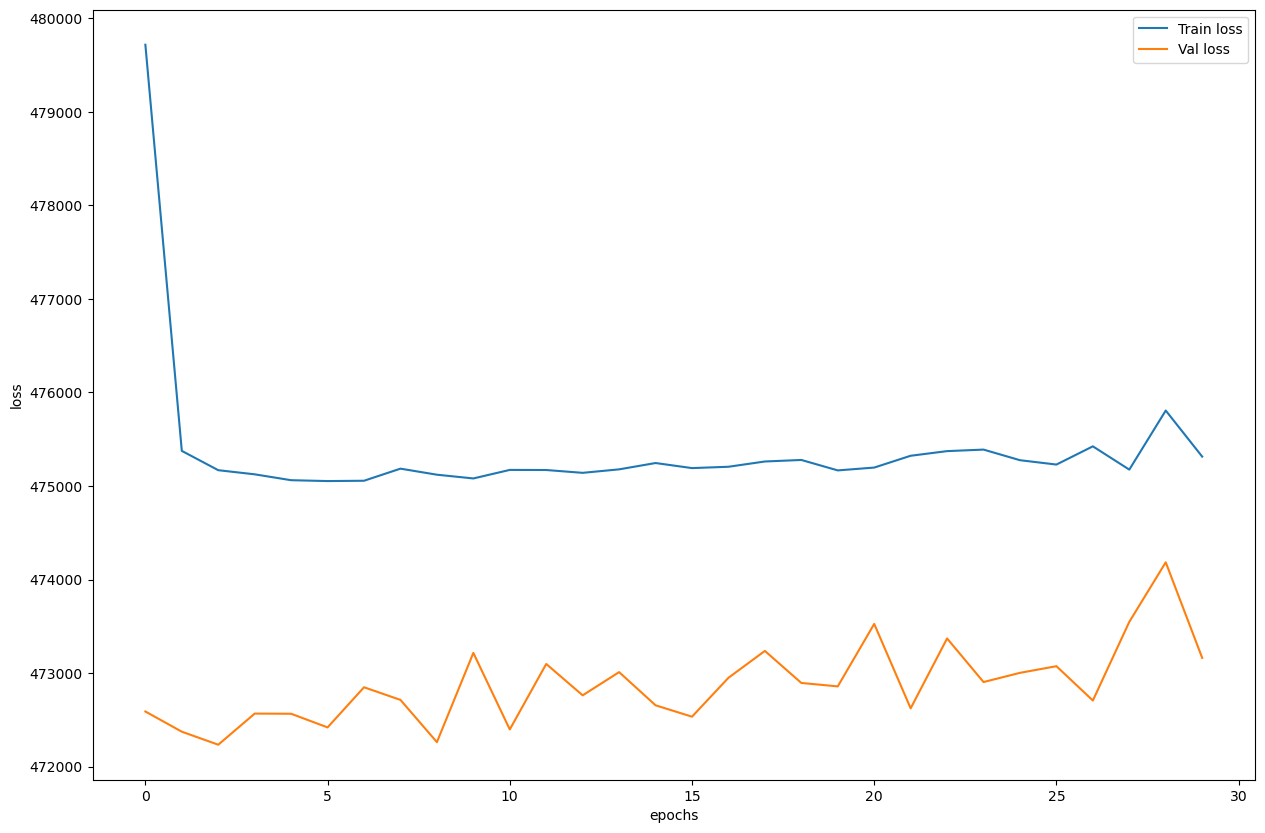

In [43]:
train_loss, val_loss = zip(*history_vae)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

## VAE生成的脸图像

(25, 256)


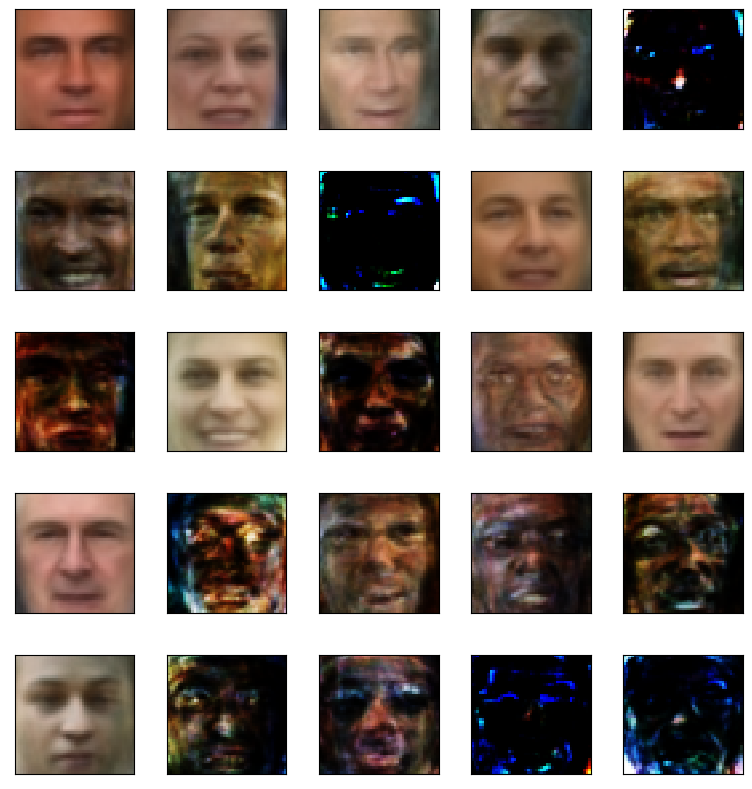

In [87]:
z = np.random.randn(25, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(DEVICE)
    model_vae.eval()
    output = model_vae.decode(inputs)
    
    decoded,mu,logvar, = model(inputs)
    outputs = decoded.view(-1, 45*45*3)
    outputs = outputs.to(DEVICE)
    
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

In [88]:
def to_latent_Vae(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(DEVICE)
        model_vae.eval()
#         output = model_vae.return_Z(inputs)
        output = model_vae.encode(inputs)[0]
        return output

def from_latent_Vae(vec):
    with torch.no_grad():
        inputs = vec.to(DEVICE)
        model_vae.eval()
        output = model_vae.decode(inputs)
        return output

In [90]:
smile_latent_Vae = to_latent_Vae(smile_data).mean(axis=0)
no_smile_latent_Vae = to_latent_Vae(no_smile_data).mean(axis=0)
sunglasses_latent_Vae = to_latent_Vae(sunglasses_data).mean(axis=0)

smile_vec = smile_latent_Vae-no_smile_latent_Vae
sunglasses_vec = sunglasses_latent_Vae - smile_latent_Vae

def make_me_smile_Vae(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent_Vae(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent_Vae(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        
def give_me_sunglasses_Vae(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent_Vae(pic)
        latent_vec[0] += sunglasses_vec
        pic_output = from_latent_Vae(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)

C:\Users\PC\AppData\Local\Temp\ipykernel_7524\1030000551.py:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



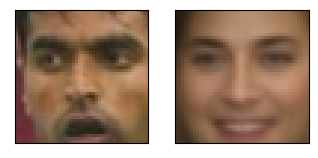

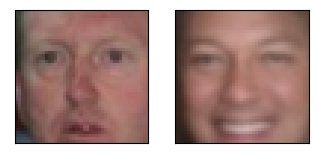

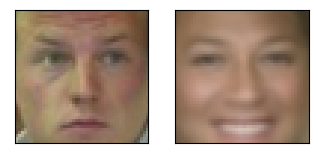

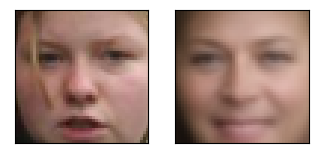

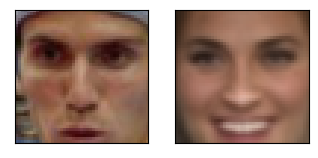

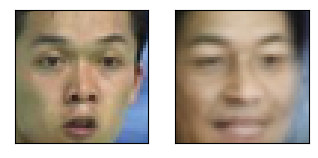

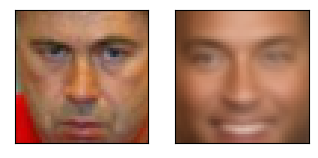

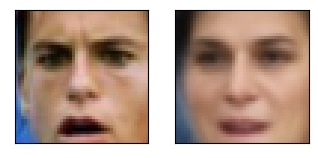

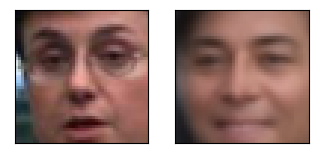

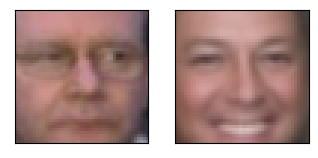

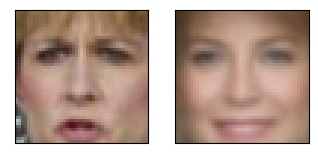

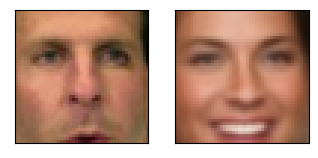

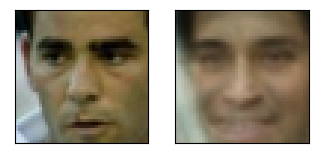

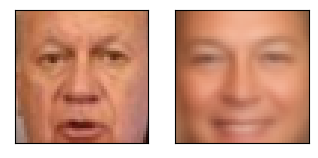

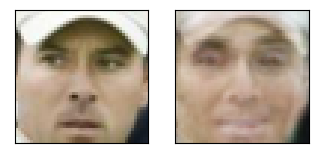

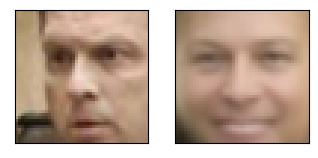

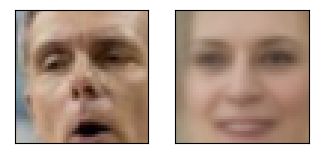

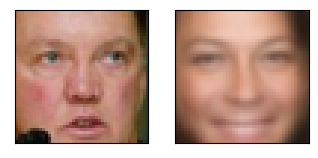

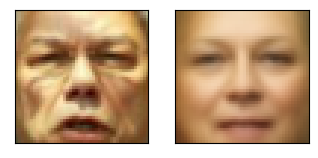

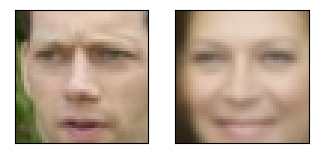

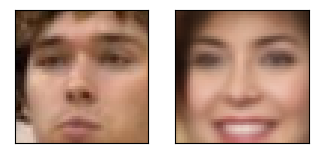

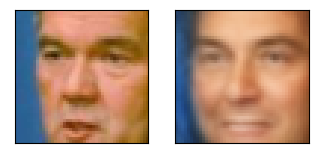

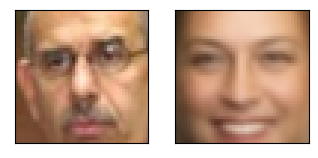

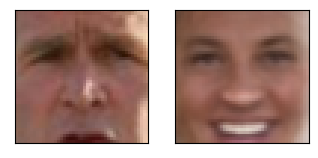

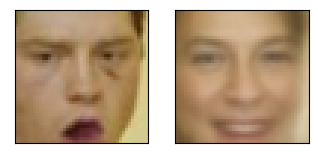

In [91]:
make_me_smile_Vae(no_smile_ids)

C:\Users\PC\AppData\Local\Temp\ipykernel_7524\1030000551.py:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



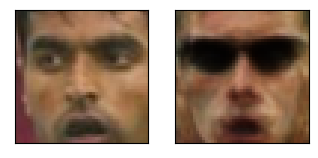

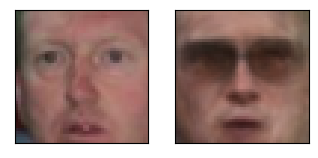

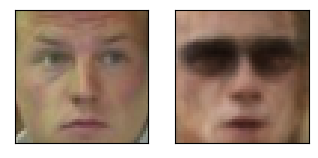

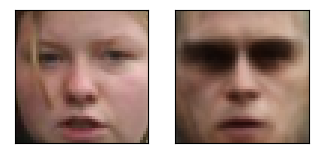

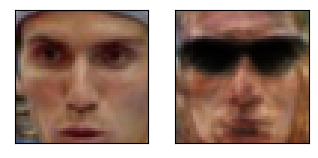

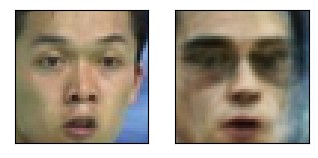

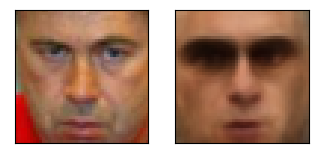

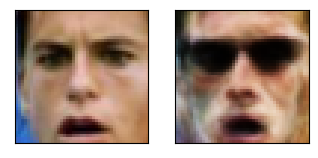

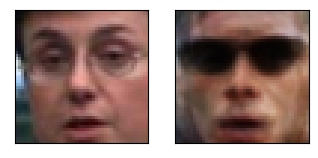

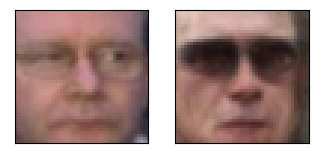

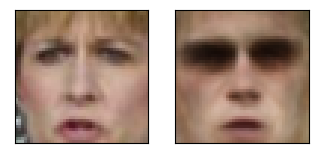

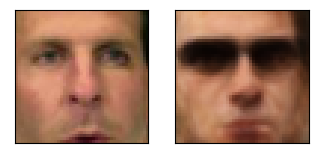

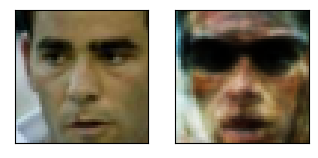

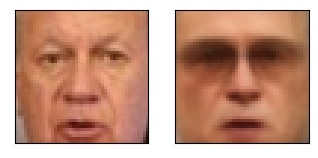

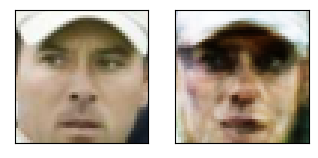

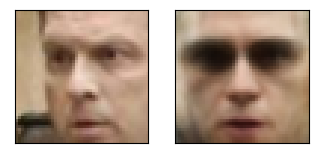

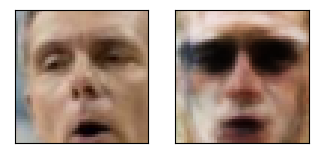

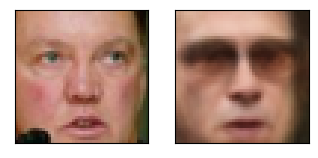

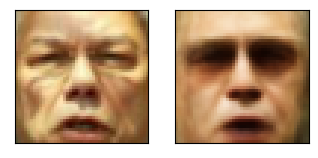

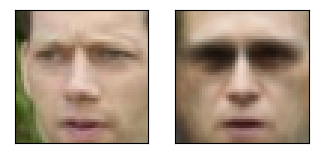

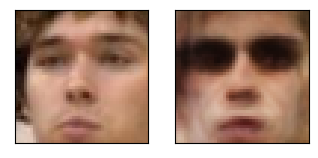

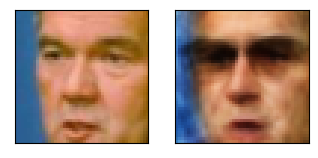

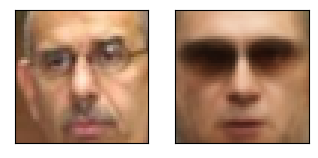

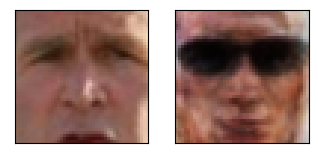

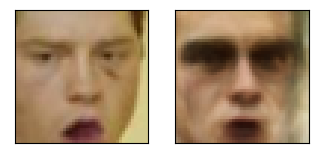

In [83]:
give_me_sunglasses_Vae(no_smile_ids)